# Rocket Design Final Code

In [1]:
#===================================================
# Project: Rocket Design and Fly (MAE 423)
# Author: Ayesha Khatun
# Python: 3.7.7
# Submission Date: 05/12/2020
#===================================================

In [2]:
# Required libraries
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

### Parameter Description
# M_L = Payload mass
# h_max = Maximum Altitude
# a_star_max = Normalized max acceleration
# SM = static margin
# rho_s = shell density (aluminum)
# rho_p = Propellant density
# sigma_s = Shell working stress
# N = Number of fins

# g = acceleration due to gravity
# P_a = Atmospheric Pressure at sea level (Pa)
# gamma = Ratio of the specific heats (C_p/C_v)
# T_a = Atmospheric Temperature(K)
# R_gas = gas constant


# Given input values in the project
M_L = 1
rho_s = 2700
rho_p = 1772
sigma_s = 60e6
N = 3

g = 9.81
P_a = 101325.
gamma = 1.4
T_a = 298.
R_gas = 287.

In [3]:
# 'M_func', 'Xcp_func', and 'Xcg_func' functions calculate 
# M, X_cp, and X_cg of Rocket's Nose, Main Tube, Fin Tube and Fins respectively.

def M_func(delta, rho_s, D, L, N):
    M_nose = rho_s*delta*np.pi*(1 + np.sqrt(5/4))* D**2
    M_maintube = rho_s*delta*np.pi*D*L
    M_fintube = rho_s*delta*np.pi*D**2
    M_fin = 0.5*N*delta*rho_s*D**2
    
    return np.array([M_nose, M_maintube, M_fintube, M_fin])


def Xcp_func(D, L):
    Xcp_nose = D*2./3.
    Xcp_maintube = D + L/2.
    Xcp_fintube = D + L + D/2.
    Xcp_fin = (D*3)/2 + L

    return np.array([Xcp_nose, Xcp_maintube, Xcp_fintube, Xcp_fin])


def Xcg_func(D, L):    
    Xcg_nose = D*2./3.
    Xcg_maintube = D + L/2.
    Xcg_fintube = D + L + D/2.
    Xcg_fin = D + L + 2.*D/3.
    
    return np.array([Xcg_nose, Xcg_maintube, Xcg_fintube, Xcg_fin])


def L_func(L, delta, rho_s, D, N, SM, R):
    M_vec_tmp = M_func(delta, rho_s, D, L, N)
    Xcp_vec_tmp = Xcp_func(D, L)
    Xcg_vec_tmp = Xcg_func(D,L)
    
    M_s_tmp = sum(M_vec_tmp)
    M_p_tmp = (R - 1)*(M_s_tmp + M_L)
    L_p_tmp = M_p_tmp/((np.pi * rho_p * D**2)/4.)
    X_cp_tmp = (sum(Xcp_vec_tmp*Cp_vec))/sum(Cp_vec)
    X_cg_tmp = ((sum(Xcg_vec_tmp*M_vec_tmp) + (.5*D*M_L) + (2*D+L-L_p_tmp/2)*M_p_tmp))/(sum(M_vec_tmp) + M_L + M_p_tmp)

    error = X_cp_tmp - X_cg_tmp - D*SM
    return (error)


Cp_vec = np.array([2,0,0,4.6384])

In [4]:
def D_func(D, P_o, R, SM, h_max, a_star_max, W_eq, M_eq, t_b):
    delta = D*P_o/2/sigma_s
    
    
    M_nose = delta*rho_s*np.pi*(1+np.sqrt(5/4))* D**2
    M_fintube = delta*rho_s*np.pi* D**2
    M_fin = 0.5*N*delta*rho_s* D**2
    L_lower = ((R - 1)*(M_L + M_nose + M_fin + M_fintube) - np.pi* D**3 *rho_p/4.)/(np.pi* D**2 *rho_p/4. - (R - 1)*np.pi*D*rho_s*delta)
    L_upper = 1000.*D
    sol_L_lower = L_func(L_lower, delta, rho_s, D, N, SM, R)
    sol_L_upper = L_func(L_upper, delta, rho_s, D, N, SM, R)
    sol_prod = sol_L_lower*sol_L_upper
    
    parameter_list = ["D", "L", "L_p", "M_s", "M_p", "M_o", "X_cp", "X_cg", "delta", "h_max", "a_star_max", "SM", "W_eq", "M_eq", "t_b"]
    
    if (sol_prod<0):
        L = optimize.brentq(L_func, L_lower, L_upper, args=(delta, rho_s, D, N, SM, R))
        M_vec = M_func(delta, rho_s, D, L, N)
        Xcp_vec = Xcp_func(D, L)
        Xcg_vec = Xcg_func(D,L)

        M_s = sum(M_vec)
        M_p = (R-1)*(M_s+M_L)
        L_p = M_p/((np.pi * rho_p * D**2)/4.)
        X_cp = (sum(Xcp_vec*Cp_vec))/sum(Cp_vec)
        X_cg = ((sum(Xcg_vec*M_vec)+(.5*D*M_L)+(2*D+L-L_p/2)*M_p))/(sum(M_vec)+M_L+M_p)
        
        M_o = M_s+ M_p+ M_L
        
        out_array = np.array([D, L, L_p, M_s, M_p, M_o, X_cp, X_cg, delta, h_max, a_star_max, SM, W_eq, M_eq, t_b])
        output = dict(zip(parameter_list, out_array))

    else:
        out_array = np.zeros(len(parameter_list))
        output = dict(zip(parameter_list, out_array))

    return output

In [5]:
## The following inputs changes; here median inputs are used.
# h_max = 10k, 20k, 30k ft
# a_star_max = 5, 10, 20
# SM = 1, 2, 3

h_max = 20000 * 0.3048
a_star_max = 10
SM = 2

R = a_star_max + 1.
W_eq = np.sqrt((h_max * g)/(((np.log(R)/2) * (np.log(R) - 2)) + ((R - 1)/R)))
a = np.sqrt(gamma*R_gas*T_a)
M_eq = W_eq/a
P_o = P_a*pow(1. + ((gamma-1.)/2.)*M_eq*M_eq,gamma/(gamma-1.))
t_b = ((R - 1) * W_eq)/(g * R)

D_values = np.arange(0.01, .201, .00005)
lmbda = np.zeros(len(D_values))
Output_list = []
i=0
for D in D_values:
    Output = D_func(D, P_o, R, SM, h_max, a_star_max, W_eq, M_eq, t_b)
    Output_list.append(Output)
    
    if Output["M_s"] == 0.:
        lmbda[i] = 0.
    else:
        lmbda[i] = M_L/(Output["M_s"]+Output["M_p"])
    i += 1

lmbda_max = np.max(lmbda)
index = np.where(lmbda==lmbda_max)[0][0]
Final_output = Output_list[index] 
Final_output["lmbda"] = lmbda_max
Final_output["epsilon"] = Final_output["M_s"]/(Final_output["M_p"]+Final_output["M_s"])

In [6]:
Final_output

{'D': 0.09219999999999949,
 'L': 0.8293008825319411,
 'L_p': 0.921461116442546,
 'M_s': 0.09016555209076871,
 'M_p': 10.901655520907687,
 'M_o': 11.991821072998455,
 'X_cp': 0.6946031072049716,
 'X_cg': 0.5102031072049725,
 'delta': 9.931994981189075e-05,
 'h_max': 6096.0,
 'a_star_max': 10.0,
 'SM': 2.0,
 'W_eq': 207.7076133676411,
 'M_eq': 0.6002598803437473,
 't_b': 19.24822661177287,
 'lmbda': 0.09097673564360617,
 'epsilon': 0.008202967596721667}

In [7]:
print('Part I: (1): Summary Table.')
print('---------------------------')
print(' ')
print("---------------------------------***INPUT***------------------------------------")
print(f'h_max      = {h_max/.3048:.1f} ft')
print(f'a_star_max = {a_star_max:.1f}')
print(f'SM         = {SM}')
print(' ')
print('----------------------------------***OUTPUT***----------------------------------')
print(f'R          = {R}')
print(f'W_eq       = {W_eq:.1f} m/s')
print(f't_b        = {t_b:.1f} sec')
print(f'p_o        = {P_o/1000000:.3f} MPa')
print(f'delta/D    = {(Final_output["delta"]/Final_output["D"]):.5f}')
print(f'D          = {Final_output["D"]:.4f} m')
print(f'L          = {Final_output["L"]:.4f} m')
print(f'X_cg       = {(100*Final_output["X_cg"]):.2f} cm')
print(f'X_cp       = {(100*Final_output["X_cp"]):.2f} cm')
print(f'M_s        = {(Final_output["M_s"]):.3f} kg')
print(f'M_p        = {(Final_output["M_p"]):.2f} kg')
print(f'M_o        = {(Final_output["M_o"]):.2f} kg')
print(f'Lambda     = {(Final_output["lmbda"]):.4f}')
print(f'Epsilon    = {(Final_output["epsilon"]):.4f}')

Part I: (1): Summary Table.
---------------------------
 
---------------------------------***INPUT***------------------------------------
h_max      = 20000.0 ft
a_star_max = 10.0
SM         = 2
 
----------------------------------***OUTPUT***----------------------------------
R          = 11.0
W_eq       = 207.7 m/s
t_b        = 19.2 sec
p_o        = 0.129 MPa
delta/D    = 0.00108
D          = 0.0922 m
L          = 0.8293 m
X_cg       = 51.02 cm
X_cp       = 69.46 cm
M_s        = 0.090 kg
M_p        = 10.90 kg
M_o        = 11.99 kg
Lambda     = 0.0910
Epsilon    = 0.0082


In [8]:
### Part I: (2,3,4): Changes in Design with h_max, a_star_max and SM

# 'plot_data_func' generates the data for comparison for a given parameter variation,choosing 
# the “median option” for the other two parameters, resulting in 9 design cases in total.

h_values = np.arange(10000, 30001, 2000)
a_values = np.arange(5,21,1.)
SM_values = np.array([1.,2.,3.])

def plot_data_func(values, hmax, amax, SM):
    data = []
    for val in values:
    
        if hmax:
            h_max = val * 0.3048
            a_star_max = 10
            SM = 2
        elif amax:
            h_max = 20000 * 0.3048
            a_star_max = val
            SM = 2
        elif SM:
            h_max = 20000 * 0.3048
            a_star_max = 10
            SM = val

        R = a_star_max + 1.
        W_eq = np.sqrt((h_max * g)/(((np.log(R)/2) * (np.log(R) - 2)) + ((R - 1)/R)))
        a = np.sqrt(gamma*R_gas*T_a)
        M_eq = W_eq/a
        P_o = P_a*pow(1. + ((gamma-1.)/2.)*M_eq*M_eq,gamma/(gamma-1.))
        t_b = ((R - 1) * W_eq)/(g * R)
        D_values = np.arange(0.01, .201, .00005)
        lmbda = np.zeros(len(D_values))

        Output_list = []
        i=0
        for D in D_values:
            Output = D_func(D, P_o, R, SM, h_max, a_star_max, W_eq, M_eq, t_b)
            Output_list.append(Output)

            if Output["M_s"] == 0.:
                lmbda[i] = 0.
            else:
                lmbda[i] = M_L/(Output["M_s"]+Output["M_p"])
            i += 1

        lmbda_max = np.max(lmbda)
        index = np.where(lmbda==lmbda_max)[0][0]
        Final_out = Output_list[index] 
        Final_out["lmbda"] = lmbda_max
        Final_out["epsilon"] = Final_out["M_s"]/(Final_out["M_p"]+Final_out["M_s"])
        data.append(Final_out)
    
    return data

In [9]:
# 'h_data' for changes in design with h_max;
# 'a_data' for changes in design with a_star_max; 
# 'SM_data' for changes in design with SM; 
h_data = plot_data_func(values=h_values, hmax=True, amax=False, SM=False)
a_data = plot_data_func(values=a_values, hmax=False, amax=True, SM=False)
SM_data = plot_data_func(values=SM_values, hmax=False, amax=False, SM=True)

In [10]:
# 'plot_func' generates plots for changes in design with h_max, a_start_max, and SM.

def plot_func(plot_data, title, xlabel, hmax, amax, SM):
    
    if hmax:
        h_max = [sub['h_max'] for sub in plot_data]
        h_max = np.rint(np.multiply(h_max, 3.28084))
        x = h_max
    elif amax:
        a_star_max = [sub['a_star_max'] for sub in plot_data]
        x = a_star_max
    elif SM:
        SM = [sub['SM'] for sub in plot_data]
        x = SM


    W_eq = [sub['W_eq'] for sub in plot_data] # in m/s
    t_b = [sub['t_b'] for sub in plot_data] # in sec
    M_p = [sub['M_p'] for sub in plot_data] # in Kg
    M_o = [sub['M_o'] for sub in plot_data] # in Kg
    X_cg = np.multiply([sub['X_cg'] for sub in plot_data], 100) # in cm
    X_cp = np.multiply([sub['X_cp'] for sub in plot_data], 100) # in cm

    ### Plot W_eq, t_b, M_p, M_o
    fig, ax = plt.subplots()
    plt.title(title, size = 14)
    plt.plot(x, W_eq, '-or', label='$W_{eq}$')
    ax.set_xlabel(xlabel, size = 14)
    ax.set_ylabel('$W_{eq}$ (m/s)', size = 14)

    # Get second Y axis
    ax2 = ax.twinx()
    plt.plot(x, t_b, '-ob', label='$t_b$')
    plt.plot(x, M_p, '-ok', label='$M_p$')
    plt.plot(x, M_o, '-oc', label='$M_o$')
    ax2.set_ylabel('$M_o$ (Kg), $M_p$ (Kg), $t_b$ (sec)', size=14)
    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    plt.legend(handles,labels)
    plt.grid()
    plt.show()

    ### plot X_cg and X_cp
    fig, ax = plt.subplots(1,1)
    plt.title(title, size = 14)
    plt.plot(x, X_cg, '-or', label='$X_{cg}$')
    plt.plot(x, X_cp, '-oc', label='$X_{cp}$')
    ax.set_xlabel(xlabel, size = 14)
    ax.set_ylabel('$X_{cg}$, $X_{cp}$ (cm)', size = 14)
    plt.legend()

    plt.grid()
    plt.show()

Part I: (2): Changes in Design with h_max


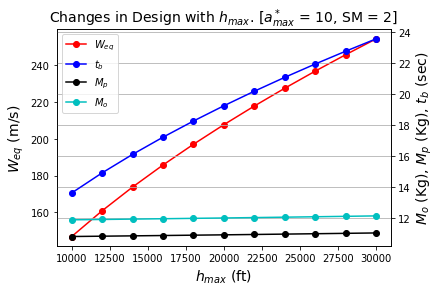

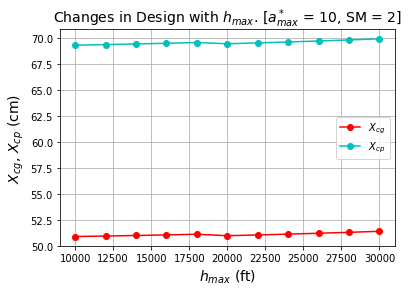

In [11]:
print('Part I: (2): Changes in Design with h_max')
plot_func(plot_data = h_data, title = 'Changes in Design with $h_{max}$. [$a^*_{max}$ = 10, SM = 2]', xlabel = '$h_{max}$ (ft)', hmax=True, amax=False, SM=False)

Part I: (3): Changes in Design with a_star_max


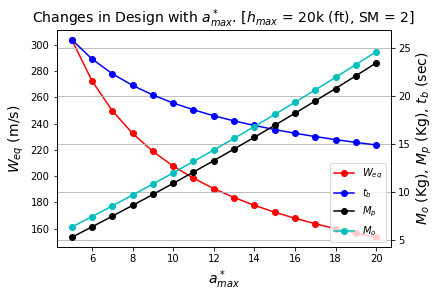

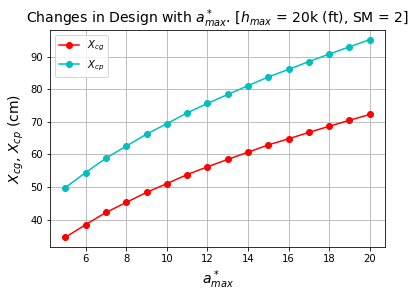

In [12]:
print('Part I: (3): Changes in Design with a_star_max')
plot_func(plot_data = a_data, title = 'Changes in Design with $a^*_{max}$. [$h_{max}$ = 20k (ft), SM = 2]', xlabel = '$a^*_{max}$', hmax=False, amax=True, SM=False)

Part I: (4): Changes in Design with SM.


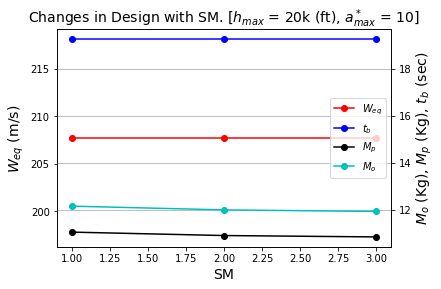

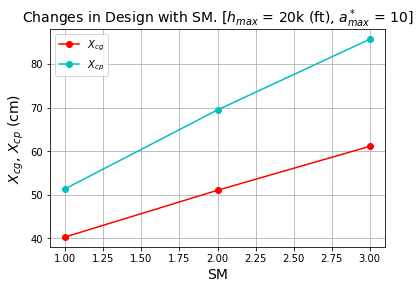

In [13]:
print('Part I: (4): Changes in Design with SM.')
plot_func(plot_data = SM_data, title = 'Changes in Design with SM. [$h_{max}$ = 20k (ft), $a^*_{max}$ = 10]', xlabel = 'SM', hmax=False, amax=False, SM=True)

# The End